# Introduction

A short notebook where some EDA is performed on the metadata for the Lumen Data Science competition (2025)

## Import libraries

In [ ]:
# Basic libraries
import os
import warnings
import numpy as np
import pandas as pd


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
from sklearn.tree import plot_tree

import scipy.stats as stats

## Helper functions

In [ ]:
def na_percentage(df):
  missing_percentage = df.isna().sum() / df.shape[0] * 100
  missing_percentage_sorted = missing_percentage.sort_values(ascending=False)
  print(missing_percentage_sorted)

In [ ]:
def numerical_histogram_with_desc_stat(df, column):

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.histplot(x=column, data=df, ax=ax).set(title=f"Histogram of {column}")

    # Add lines
    ax.axvline(upper_limit, linewidth=3, color="red", label="Upper Limit")
    ax.axvline(lower_limit, linewidth=3, color="red", label="Lower Limit")
    ax.axvline(df[column].mean(), linewidth=3, color="yellow", label="Mean")
    ax.axvline(df[column].median(), linewidth=3, color="black", label="Median")

    ax.legend()

In [ ]:
def categorical_normalized_box_plot(df, column, ax):

    submarket_counts = df[column].value_counts(normalize=True).reset_index()
    submarket_counts.columns = ['category', 'proportion']

    sns.barplot(
        x='category',
        y='proportion',
        hue='category',
        data=submarket_counts,
        ax=ax,
        palette=sns.color_palette("husl", len(submarket_counts)),
        dodge=False,
        legend=False
    )

    ax.set_title(column)
    ax.set_xticks(range(len(submarket_counts)))
    ax.set_xticklabels(submarket_counts['category'], rotation=90)


In [ ]:
def numerical_qq_plot(df, column):
    fig, ax = plt.subplots(figsize=(8, 6))
    stats.probplot(df[column].dropna(), dist="norm", plot=ax)
    ax.set_title(f"Q-Q Plot for {column}")

In [ ]:
def categorical_vs_target_categorical(df, categorical_column, ax):
    #stacked_barplot
    target = 'benign_malignant'


    # Calculate proportions for better comparison
    grouped = df.groupby([categorical_column, target]).size().reset_index(name='count')
    grouped['proportion'] = grouped.groupby(categorical_column)['count'].transform(lambda x: x / x.sum())

    pivot_table = grouped.pivot(index=categorical_column, columns=target, values='proportion').fillna(0)


    pivot_table.plot(
        kind='bar',
        stacked=True,
        ax=ax,
        colormap='rainbow',
        legend=True
    )

    # Customize plot
    ax.set_title(f"{categorical_column} vs benign_malignant (Stacked)")
    ax.set_ylabel("Proportion")
    ax.set_xlabel(categorical_column)
    ax.legend(title='benign_malignant', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xticks(range(len(pivot_table.index)))
    ax.set_xticklabels(pivot_table.index, rotation=90)

In [ ]:
def numerical_vs_target_categorical(df, numeric_column, ax):
    #_distplot
    sns.kdeplot(
        data=df,
        x=numeric_column,
        hue= 'benign_malignant',
        fill=True,
        common_norm=False,
        alpha=0.5,
        ax=ax
    )
    ax.set_title(f"{numeric_column} vs benign_malignant")

In [ ]:
def visualize_grid(df, columns, func, grid_cols=3):

    n_rows = -(-len(columns) // grid_cols)
    fig, axes = plt.subplots(n_rows, grid_cols, figsize=(grid_cols * 5, n_rows * 5))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        func(df, column, axes[i])

    for j in range(len(columns), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

## Load data

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
data_path = "/content/gdrive/MyDrive/LUMEN_natjecanje/Data/"
file_name = "ISIC_2020_Training_GroundTruth_v2.csv"

In [ ]:
df = pd.read_csv(os.path.join(data_path, file_name) )
df.shape

(33126, 9)

In [ ]:
df.head()

,image_name,patient_id,lesion_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,IL_7972535,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,IL_4649854,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,IL_9087444,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,IL_4255399,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,IL_6898037,female,55.0,upper extremity,unknown,benign,0


## Attribute information

# EDA

## Dropping useless columns

- Target is equal to benign_malignant, so there is no use keeping them both
- The other columns are dropped because they are just IDs

In [ ]:
columns_to_drop = ['image_name', 'patient_id', 'lesion_id', 'target']
df = df.drop(columns_to_drop, axis = 1)

In [ ]:
cat_col = ['sex', 'anatom_site_general_challenge', 'diagnosis']
num_col = ['age_approx']

## Checking for missing values

In [ ]:
na_percentage(df)

anatom_site_general_challenge    1.590895
age_approx                       0.205277
sex                              0.196220
diagnosis                        0.000000
benign_malignant                 0.000000
dtype: float64


## Univariate analysis

### Numerical features

In [ ]:
df[num_col].describe()

,age_approx
count,33058.000000
mean,48.870016
std,14.380360
min,0.000000
25%,40.000000
50%,50.000000
75%,60.000000
max,90.000000


Age has a normal distribution and it does not contain outliers

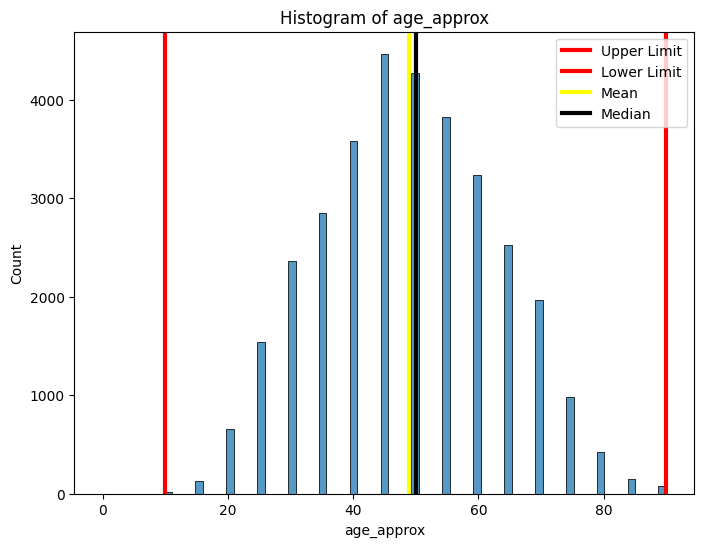

In [ ]:
numerical_histogram_with_desc_stat(df, 'age_approx')

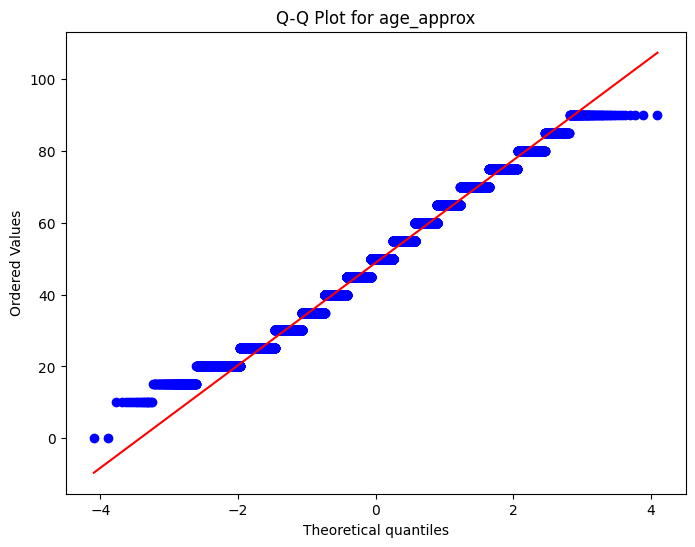

In [ ]:
numerical_qq_plot(df, 'age_approx')

### Categorical features

Pretty self explanitory

In [ ]:
for column in cat_col:
    print(df[column].value_counts(normalize=True))
    print('-------------')

sex
male      0.516621
female    0.483379
Name: proportion, dtype: float64
-------------
anatom_site_general_challenge
torso              0.516734
lower extremity    0.258198
upper extremity    0.152857
head/neck          0.056904
palms/soles        0.011503
oral/genital       0.003804
Name: proportion, dtype: float64
-------------
diagnosis
unknown                               0.818813
nevus                                 0.156765
melanoma                              0.017630
seborrheic keratosis                  0.004075
lentigo NOS                           0.001328
lichenoid keratosis                   0.001117
solar lentigo                         0.000211
cafe-au-lait macule                   0.000030
atypical melanocytic proliferation    0.000030
Name: proportion, dtype: float64
-------------


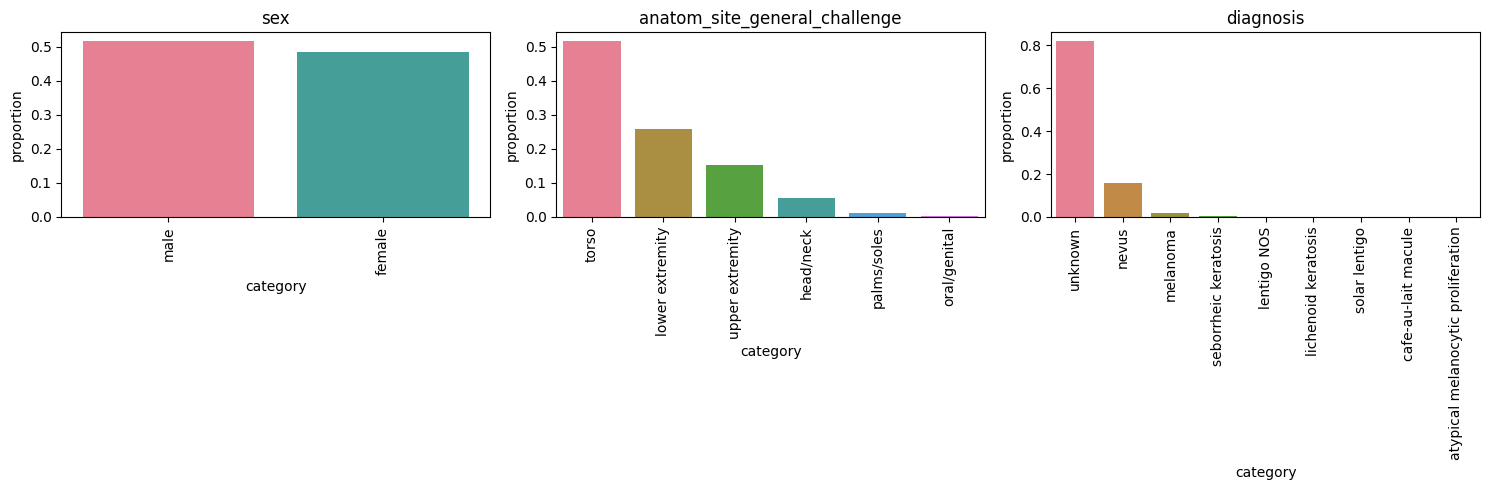

In [ ]:
visualize_grid(df, cat_col, categorical_normalized_box_plot, 3)

### Target feature

Target feature is extremelly unbalanced

In [ ]:
print(df['benign_malignant'].value_counts(normalize=True))

benign_malignant
benign       0.98237
malignant    0.01763
Name: proportion, dtype: float64


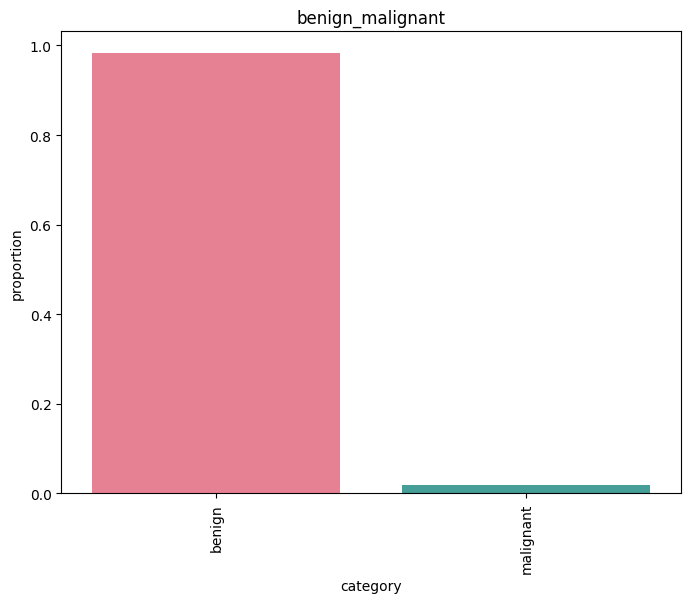

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
categorical_normalized_box_plot(df, 'benign_malignant', ax)

## Multivariate analysis

Age seems to have some influence on the target feature

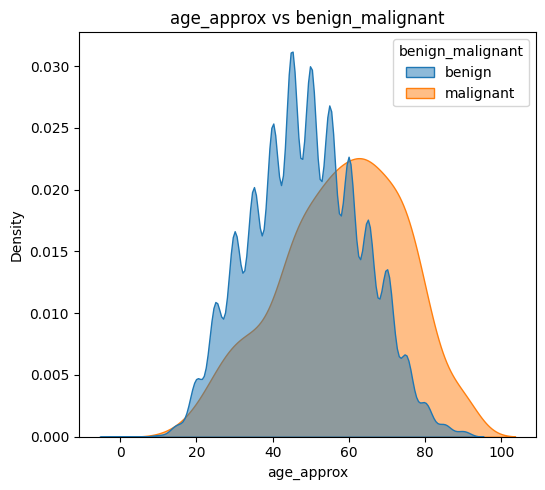

In [ ]:
visualize_grid(df, num_col, numerical_vs_target_categorical)

- Sex and anatomical site seem not to have any influence on the target.
- Diagnosis is equvalient to target feature

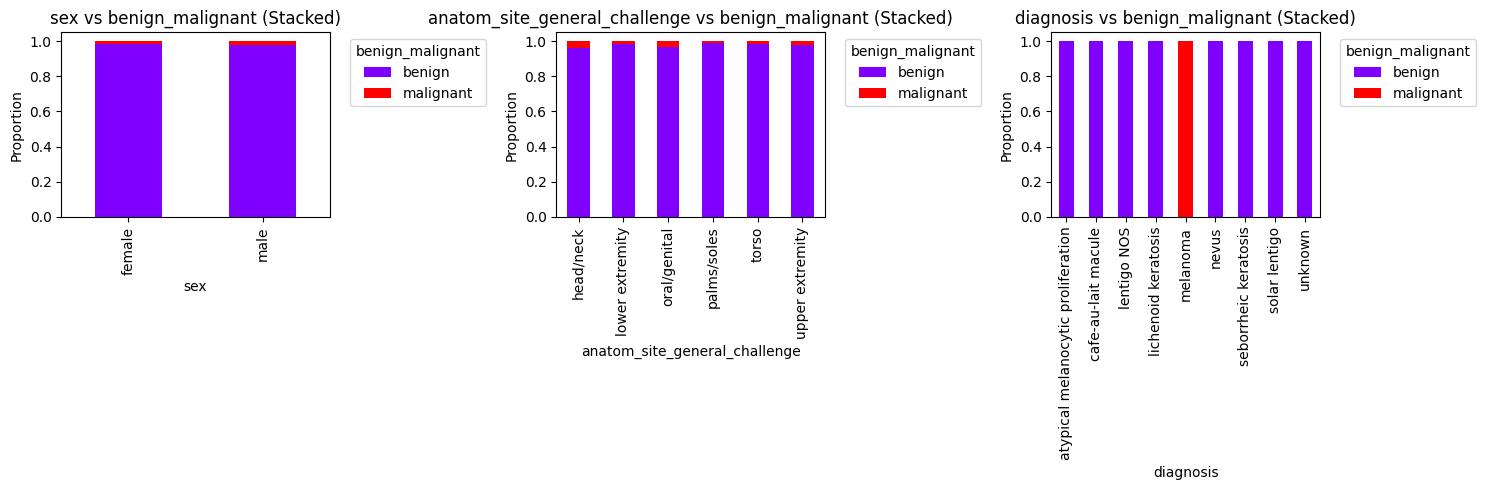

In [ ]:
visualize_grid(df, cat_col, categorical_vs_target_categorical, 3)

## Conclusion

- Age is normaly distributed
- No outliers
- Out of all the features, it seems that only age has significant influence on the target feature
- Target feature is extremelly unbalanced
